# Validation

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
import sys
import pickle
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# load environment variables
load_dotenv()

#add working directory to sys path to execute utils/dataset.py
working_dir = os.environ.get("WORKING_DIRECTORY")
sys.path.insert(0, working_dir)

from utils.pipeline_moduls import outlier_label, outlier_num


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataset import get_data 
df = get_data()
df.head(10)

#sample data to 1000 rows
df = df.sample(1000, random_state=42)

Loading data from wines: 8000it [00:00, 21670.75it/s]


In [4]:
#TODO: add load valdiation data from csv
#df = pd.read_csv('./data/validation.csv')

In [5]:
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=[np.number]).columns
#drop 'quality' from numerical features (its a series)
numerical_features = numerical_features.drop('quality')
label = pd.Series('quality')

## Cleaning Pipeline

### Methods

In [6]:
outlier_detection_label = FunctionTransformer(outlier_label).set_output(transform="pandas")
outlier_detection = FunctionTransformer(outlier_num).set_output(transform="pandas")

def feature_selection(df, json_file: str = "./task_2/dropped_features.json"):
    try:
        with open(json_file, 'r') as f:
            dropped_features = json.load(f)
    except FileNotFoundError:
        print(f"File {json_file} not found")
        return None

    # Find common features between DataFrame columns and dropped features
    common_features = list(set(df.columns).intersection(dropped_features))
    if not common_features:
        print("No dropped features found in the DataFrame.")
        return df
    
    # Remove the common features from the DataFrame
    df = df.drop(common_features, axis=1)
    print("Working with following columns:", df.columns.values)
    return df
feature_selection = FunctionTransformer(feature_selection).set_output(transform="pandas")

/opt/anaconda3/envs/data-science/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


#### Sub-Pipeline: Categorical Features

In [7]:
categorical_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")

#pipeline for categorical features
categorical_pipeline = Pipeline(steps=[])
categorical_pipeline.steps.append(('imputer', categorical_imputer))
categorical_pipeline.steps.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")))

#### Sub-Pipeline: Numerical Features

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

In [9]:
#pipeline for numerical features without scaling
numeric_pipeline = Pipeline(steps=[])
numerical_imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

numeric_pipeline.steps.append(('imputer', numerical_imputer))
numeric_pipeline.steps.append(('outlier_detection', outlier_detection))


In [10]:
#pipeline for numerical features with scaling
numeric_pipeline_scaled = Pipeline(steps=[])
numerical_imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

numeric_pipeline_scaled.steps.append(('imputer', numerical_imputer))
numeric_pipeline_scaled.steps.append(('outlier_detection', outlier_detection))
numeric_pipeline_scaled.steps.append(('scaler', scaler_minmax))

#### Sub-Pipeline: Label

In [11]:
#pipeline for label
label_pipeline = Pipeline(steps=[])
label_pipeline.steps.append(('imputer', numerical_imputer))


### Pipeline

In [12]:
cleaning_pipeline = Pipeline(steps=[
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")
cleaning_pipeline.steps.append(('preprocessor', preprocessor))
cleaning_pipeline.steps.append(("outlier_detection_label", outlier_detection_label))
cleaning_pipeline.steps.append(('feature_selection', feature_selection))
cleaning_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_num at 0x12bf34180>))]),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'magnesium', 'flavanoids', 'minerals', 'calcium', 'chlorides',
       'free sulfur dioxide', 'to...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  0    quality
dtype: object)])),
                ('outlier_detection_label',
                 FunctionTransformer(func=<function outlier_label at 0x12b07d1c0>)),
                ('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x12defcae0>))])

In [14]:
cleaning_pipeline_scaled = Pipeline(steps=[
])

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_scaled, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('label', label_pipeline, label)
    ]).set_output(transform="pandas")
cleaning_pipeline_scaled.steps.append(('preprocessor', preprocessor))
cleaning_pipeline_scaled.steps.append(("outlier_detection_label", outlier_detection_label))
cleaning_pipeline_scaled.steps.append(('feature_selection', feature_selection))
cleaning_pipeline_scaled

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier_detection',
                                                                   FunctionTransformer(func=<function outlier_num at 0x12bf34180>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'magnesium', 'flavanoids', 'minerals', 'calcium', 'chloride...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['wine type'], dtype='object')),
                                                 ('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  0    quality
dtype: object)])),
                ('outlier_detection_label',
                 FunctionTransformer(func=<function outlier_label at 0x12b07d1c0>)),
                ('feature_selection',
                 FunctionTransformer(func=<function feature_selection at 0x12defcae0>))])

## Validation of our trained models

### KNN
with scaled data

In [16]:
def run_KNN(df):

    cleaned_data = cleaning_pipeline_scaled.fit_transform(df)

    #load model with pickle
    model = pickle.load(open('./task_2/models/7000_samples/KNN.pkl', 'rb'))
    X = cleaned_data.drop('label__quality', axis=1)
    y = cleaned_data['label__quality']
    print("----------------------------------------")
    print("Accuracy:", model.score(X, y))
    print("----------------------------------------")
    

run_KNN(df)

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------


ValueError: Input contains NaN.

## Random Forest Regressor
without scaled data

In [ ]:
def run_random_forest_regressor(df):

    cleaned_data = cleaning_pipeline.fit_transform(df)

    #load model with pickle
    model = pickle.load(open('./task_2/models/RandomForestRegressor.pkl', 'rb'))
    X = cleaned_data.drop('label__quality', axis=1)
    y = cleaned_data['label__quality']
    print("----------------------------------------")
    print("Accuracy:", model.score(X, y))
    print("----------------------------------------")
    

run_random_forest_regressor(df)

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.9617388140878089
----------------------------------------


## Gradient Boosting Regressor
without scaled data

In [ ]:
def run_gradient_boosting_regressor(df):

    cleaned_data = cleaning_pipeline.fit_transform(df)

    #load model with pickle
    model = pickle.load(open('./task_2/models/Gradient Boosting Regressor.pkl', 'rb'))
    X = cleaned_data.drop('label__quality', axis=1)
    y = cleaned_data['label__quality']
    print("----------------------------------------")
    print("Accuracy:", model.score(X, y))
    print("----------------------------------------")
    

run_gradient_boosting_regressor(df)

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------
Accuracy: 0.9823787599976226
----------------------------------------


## Optional: andere Modelle


### DecisionTreeRegressor
without scaled data

In [17]:
#calculate mse and r2 score
def run_decision_tree_regressor(df):

    cleaned_data = cleaning_pipeline.fit_transform(df)

    #load model with pickle
    model = pickle.load(open('./task_2/models/DecisionTreeRegressor.pkl', 'rb'))
    X = cleaned_data.drop('label__quality', axis=1)
    y = cleaned_data['label__quality']
    print("----------------------------------------")
    print("Accuracy:", model.score(X, y))
    print("R2 score:", r2_score(y, model.predict(X)))
    print("MSE:", mean_squared_error(y, model.predict(X)))
    print("----------------------------------------")
    

run_decision_tree_regressor(df)

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__magnesium' 'num__flavanoids' 'num__chlorides'
 'num__total sulfur dioxide' 'num__density' 'num__pH' 'num__sulphates'
 'num__alcohol' 'cat__wine type_Cabernet Sauvignon'
 'cat__wine type_Chardonnay' 'cat__wine type_Gamay'
 'cat__wine type_Merlot' 'label__quality']
----------------------------------------


ValueError: Input contains NaN.

### LinearRegression
without scaled data

Working with following columns: ['num__fixed acidity' 'num__volatile acidity' 'num__citric acid'
 'num__residual sugar' 'num__magnesium' 'num__flavanoids' 'num__calcium'
 'num__chlorides' 'num__density' 'num__pH' 'num__sulphates' 'num__alcohol'
 'cat__wine type_Cabernet Sauvignon' 'cat__wine type_Chardonnay'
 'cat__wine type_Gamay' 'cat__wine type_Merlot' 'label__quality']


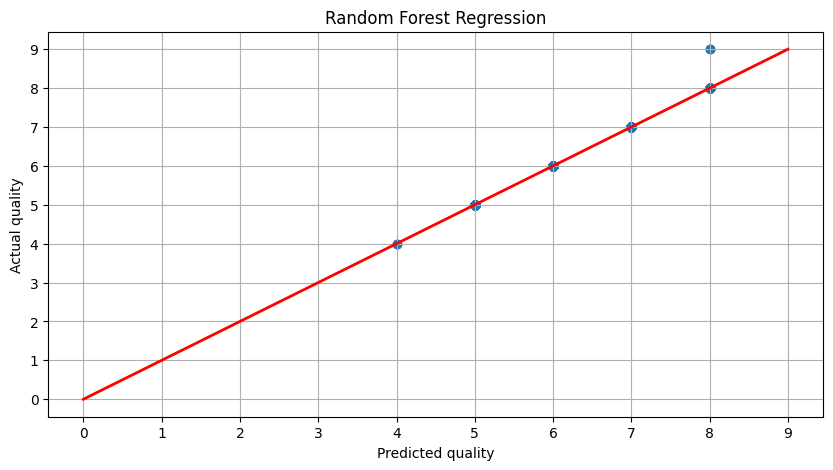

In [33]:
#visualize the model
model = pickle.load(open('./task_2/models/DecisionTreeRegressor.pkl', 'rb'))
cleaned_data = cleaning_pipeline.fit_transform(df)
X = cleaned_data.drop('label__quality', axis=1)
y = cleaned_data['label__quality']

#predict label__quality
prediction = model.predict(X)



plt.figure(figsize=(10,5))
plt.scatter(prediction, y)
plt.plot([0, 9], [0, 9], color='red', linewidth=2)
plt.xlabel('Predicted quality')
plt.ylabel('Actual quality')
plt.title('Random Forest Regression')
plt.grid(True)
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.show()



In [35]:
#display decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X.columns.values,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_regressor")
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [149]:
#check whicht y values are not whole numbers
y[y.apply(lambda x: x.is_integer()) == False]


318     6.2
1888    5.6
6213    5.2
4228    6.2
4511    5.8
511     5.8
Name: label__quality, dtype: float64

In [160]:
prediction

array([4. , 6. , 5. , 6. , 5. , 6. , 5. , 6. , 7. , 6. , 6. , 6. , 6. ,
       6. , 5. , 6. , 6. , 6. , 1. , 6. , 5. , 6. , 6. , 6. , 6. , 7. ,
       6. , 7. , 5. , 5. , 7. , 6. , 8. , 6. , 1. , 7. , 7. , 6. , 6. ,
       5. , 5. , 7. , 6. , 6. , 1. , 6. , 7. , 8. , 5. , 8. , 5. , 5. ,
       7. , 5. , 7. , 6. , 5. , 6. , 6. , 8. , 5. , 5. , 7. , 5. , 6. ,
       6. , 7. , 6. , 4. , 6. , 6. , 5. , 6. , 7. , 6. , 2. , 6. , 5. ,
       5. , 7. , 5. , 5. , 5. , 6. , 6. , 7. , 6. , 7. , 6. , 6. , 7. ,
       5. , 8. , 6. , 6. , 6. , 5. , 6. , 7. , 6. , 6. , 6. , 6. , 5. ,
       6. , 6. , 6. , 5. , 6. , 5. , 7. , 7. , 5. , 6. , 4. , 6. , 6. ,
       5. , 7. , 6. , 6. , 5. , 7. , 7. , 6. , 5. , 4. , 5. , 5. , 6. ,
       5. , 8. , 8. , 7. , 5. , 5. , 2. , 4. , 5. , 7. , 5. , 7. , 6. ,
       6. , 6. , 6. , 6. , 5. , 6. , 8. , 6. , 7. , 6. , 6. , 5. , 6. ,
       6. , 8. , 8. , 7. , 7. , 7. , 6. , 2. , 7. , 6. , 7. , 6. , 7. ,
       5. , 4. , 6. , 6. , 7. , 5. , 7. , 6. , 6. , 6. , 7. , 6.